In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time 
from scipy.signal import convolve2d


In [2]:
def get_img_mat(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    return img_array

def get_gray_img_mat(img_path):
    img = Image.open(img_path).convert('L')
    img_array = np.array(img)
    return img_array


In [121]:
def measure_time(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Function '{func.__name__}' took {duration:.6f} seconds to run.")
        return result
    return wrapper


def expand_image(img, expanded_size):
    # Create the expanded image with zeros
    expanded_img = np.zeros(expanded_size)
    # Create the gaussian kernel
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 4
    # Upsample the input image
    # Adjust the slicing to match the desired size exactly
    expanded_img[:img.shape[0]*2:2, :img.shape[1]*2:2] = img
    # Perform the blur
    expanded_img = np.round(convolve(expanded_img, kernel))
    return expanded_img


def convolve(image, kernel):
    # Perform the convolution using scipy.signal.convolve2d
    result = convolve2d(image, kernel, mode='same', boundary='symm')
    return result


def reduce_image(img, reduced_img_size, should_blur=True):
    # Create the gaussian kernel
    kernel = np.array([[1, 2, 1], [2, 4, 2], [1, 2, 1]]) / 16
    # Perform the blur
    if should_blur:
        img = np.round(convolve(img, kernel))
    
    # Use array slicing and reshaping to select every second element
    reduced_img = img[:reduced_img_size[0] * 2:2, :reduced_img_size[1] * 2:2]
    
    return reduced_img



def get_reduced_size(img, factor=2):
    return (img.shape[0]//factor, img.shape[1]//factor)


def get_max_level(img):
    return int(np.log2(min(img.shape[0], img.shape[1])))-1

# @measure_time
def create_pyramid(img):
    pyramid = []
    pyramid.append({'G' : img})
    reduced_img = img
    for i in range(1, get_max_level(img)):
        reduced_img_size = get_reduced_size(reduced_img, 2)
        reduced_img = reduce_image(reduced_img, reduced_img_size)
        expanded_image_size = pyramid[i-1]['G'].shape
        expanded_img = expand_image(reduced_img, expanded_image_size)
        pyramid.append({'G': reduced_img, 'Expanded_G': expanded_img})
        
    for i in range(len(pyramid)-1):
        pyramid[i]['L'] = pyramid[i]['G'] - pyramid[i+1]['Expanded_G']
    return pyramid

def plot_pyramid(pyramid):
    plt.subplots(1, len(pyramid), figsize=(20, 20))
    for i in range(len(pyramid)):
        plt.subplot(1, len(pyramid), i+1)
        plt.imshow(pyramid[i]['G'], cmap="gray")
        plt.title(f"Level {i}")
    plt.show()

def plot_pyramid_diff(pyramid):
    plt.subplots(1, len(pyramid)-1, figsize=(20, 20))
    for i in range(len(pyramid)-1):
        plt.subplot(1, len(pyramid)-1, i+1)
        plt.imshow(pyramid[i]['L'], cmap="gray")
        plt.title(f"Level {i} - Level {i+1}")
    plt.show()


def get_mask_pyramid(mask):
    mask = mask//255
    mask_pyramid = []
    mask_pyramid.append({'G' : mask})
    reduced_mask = mask
    for i in range(1, get_max_level(mask)):
        reduced_mask_size = get_reduced_size(reduced_mask, 2)
        reduced_mask = reduce_image(reduced_mask, reduced_mask_size, False)
        mask_pyramid.append({'G': reduced_mask})
    return mask_pyramid       


def reconstruct_image(pyramid):
    reconstructed_img = pyramid[-1]['G']
    for i in range(len(pyramid)-2, -1, -1):
        expanded_img = expand_image(reconstructed_img, pyramid[i]['L'].shape)
        reconstructed_img = expanded_img + pyramid[i]['L']
    return reconstructed_img


def blend_pyramids(pyramid1, pyramid2, mask_pyramid, max_level):
    blended_pyramid = []
    i = 0
    for i in range(max_level):
        blended_pyramid.append({'L': pyramid1[i]['L']*mask_pyramid[i]['G'] + (1-mask_pyramid[i]['G'])*pyramid2[i]['L']})
    # the last level is blended differently 
    blended_pyramid.append({'G': pyramid1[i+1]['G']*mask_pyramid[i+1]['G'] + (1-mask_pyramid[i+1]['G'])*pyramid2[i+1]['G']})
    return blended_pyramid

def rgb_to_yiq(img):        
    # Conversion matrix from RGB to YIQ
    conversion_matrix = np.array([[0.299, 0.587, 0.114],
                                  [0.595716, -0.274453, -0.321263],
                                  [0.211456, -0.522591, 0.311135]])
    # Apply the conversion matrix
    yiq_image = np.dot(img.astype(float), conversion_matrix.T)
    
    # Clip values to [0, 255] range and convert to integers
    yiq_image = np.clip(yiq_image, 0, 255).astype(int)
    
    return yiq_image

def yiq_to_rgb(img_array):
    # Conversion matrix from YIQ to RGB
    conversion_matrix = np.array([[1, 0.9663, 0.6210],
                                  [1, -0.2721, -0.6474],
                                  [1, -1.1070, 1.7046]])
    
    # Apply the conversion matrix
    rgb_image = np.dot(img_array.astype(float), conversion_matrix.T)
    
    # Clip values to [0, 255] range and convert to integers
    rgb_image = np.clip(rgb_image, 0, 255).astype(int)
    
    return rgb_image



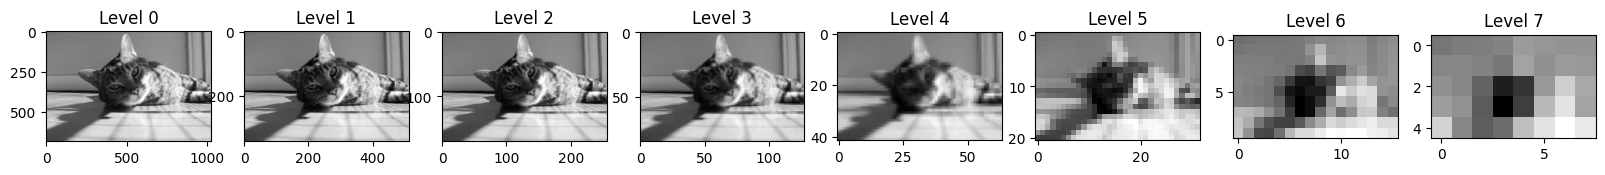

In [108]:
img = get_gray_img_mat('./assets/grayscale-cat.jpeg')
pyramid = create_pyramid(img)
plot_pyramid(pyramid)

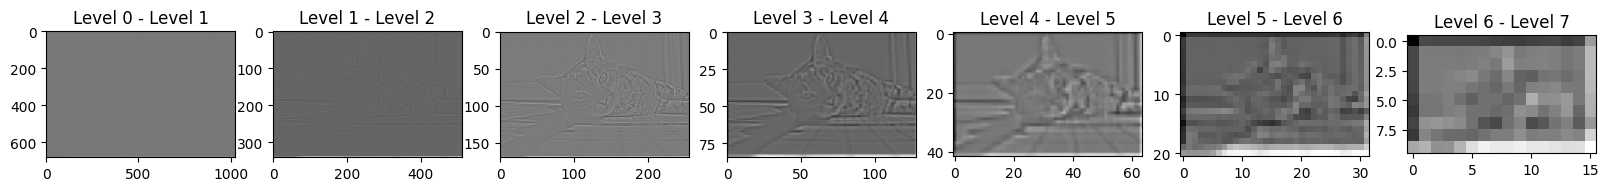

In [109]:
plot_pyramid_diff(pyramid)


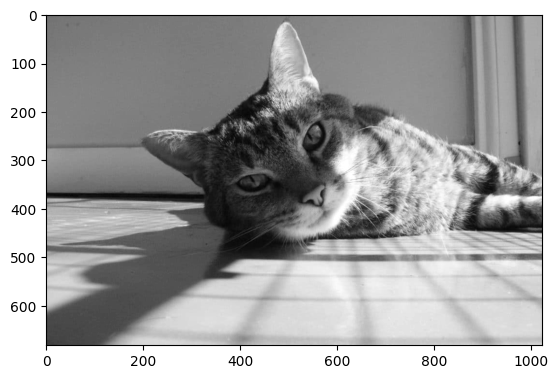

In [20]:
reconstructed_img = reconstruct_image(pyramid)
plt.imshow(reconstructed_img, cmap="gray")

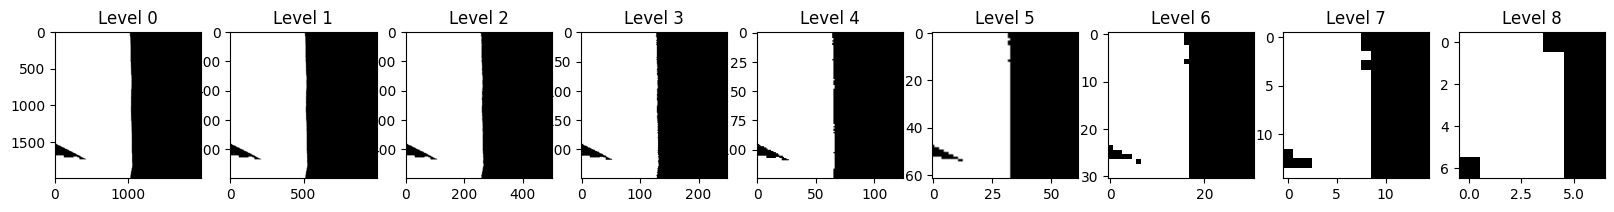

In [135]:
mask = get_gray_img_mat('./assets/mask.jpeg')
mask_pyramid = get_mask_pyramid(mask)
plot_pyramid(mask_pyramid)

In [68]:
#the method opens an image based on its path and return 3 matrices in Y, I and Q color spaces
def open_image(img_path):
    img = Image.open(img_path)
    img_array = np.array(img)
    return rgb_to_yiq(img_array)


import concurrent.futures

def blend_images(img1, img2, mask, max_level):
    with (concurrent.futures.ThreadPoolExecutor() as executor):
        img1_pyramid_a, img1_pyramid_b, img1_pyramid_c, img2_pyramid_a, img2_pyramid_b, img2_pyramid_c = executor.map(create_pyramid, 
                                                                                                                      (img1[:,:,0], img1[:,:,1], img1[:,:,2], img2[:,:,0], img2[:,:,1], img2[:,:,2]))        
        mask_pyramid = get_mask_pyramid(mask)
        blended_pyramid_a = blend_pyramids(img1_pyramid_a, img2_pyramid_a, mask_pyramid, max_level)
        blended_pyramid_b = blend_pyramids(img1_pyramid_b, img2_pyramid_b, mask_pyramid, max_level)
        blended_pyramid_c = blend_pyramids(img1_pyramid_c, img2_pyramid_c, mask_pyramid, max_level)
    return yiq_to_rgb(np.dstack((reconstruct_image(blended_pyramid_a), reconstruct_image(blended_pyramid_b), reconstruct_image(blended_pyramid_c))))
    

In [25]:
img_1 = open_image('./assets/apple.jpeg')
img_2 = open_image('./assets/orange.jpeg')
mask = get_gray_img_mat('./assets/mask.jpeg')
blended_img = blend_images(img_1, img_2, mask)

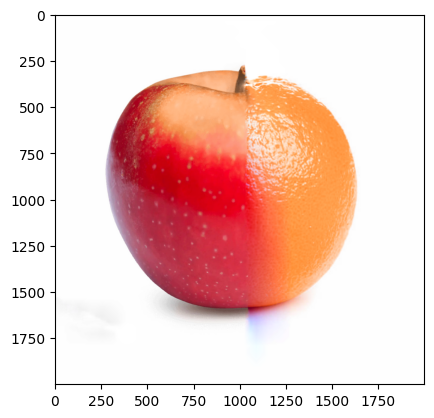

In [26]:
plt.imshow(blended_img)

In [152]:
img = rgb_to_yiq('./assets/apple.jpeg')

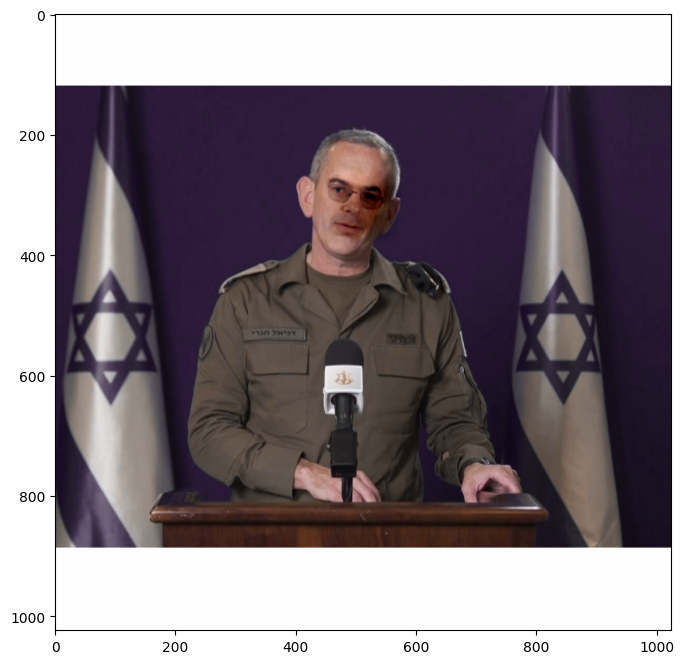

In [128]:
img1 = open_image('./assets/shmuel.png')
img2 = open_image('./assets/meme.png')
mask= get_gray_img_mat('./assets/mask2.png')
blended_img = blend_images(img1, img2, mask, 8)
plt.figure(figsize=(10, 8))  # Adjust the width and height as needed
plt.imshow(blended_img)

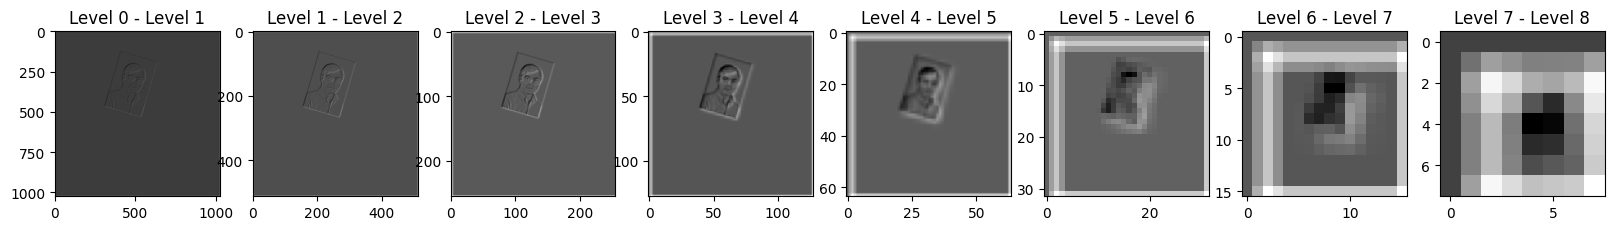

In [100]:
pyramid = create_pyramid(img1[:,:,0])
pyramid2 = create_pyramid(img2[:,:,0])
mask_pyramid = get_mask_pyramid(mask)
plot_pyramid_diff(pyramid)

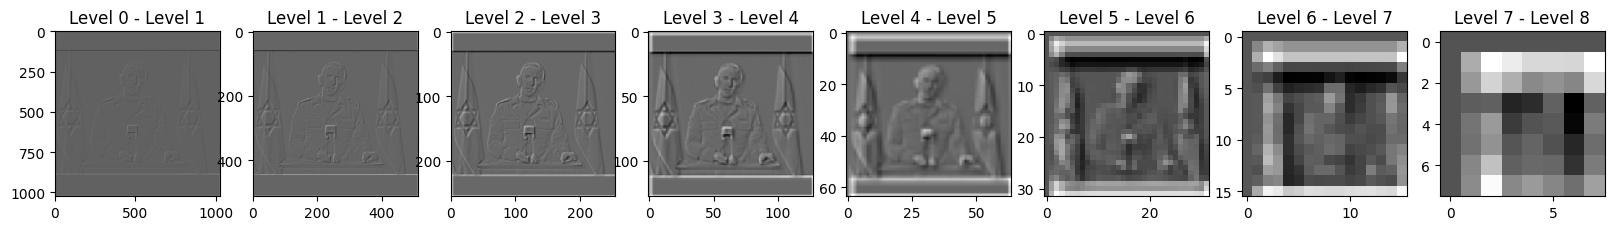

In [101]:
plot_pyramid_diff(pyramid2)

In [103]:
blended_pyramid = blend_pyramids(pyramid, pyramid2, mask_pyramid, 5)

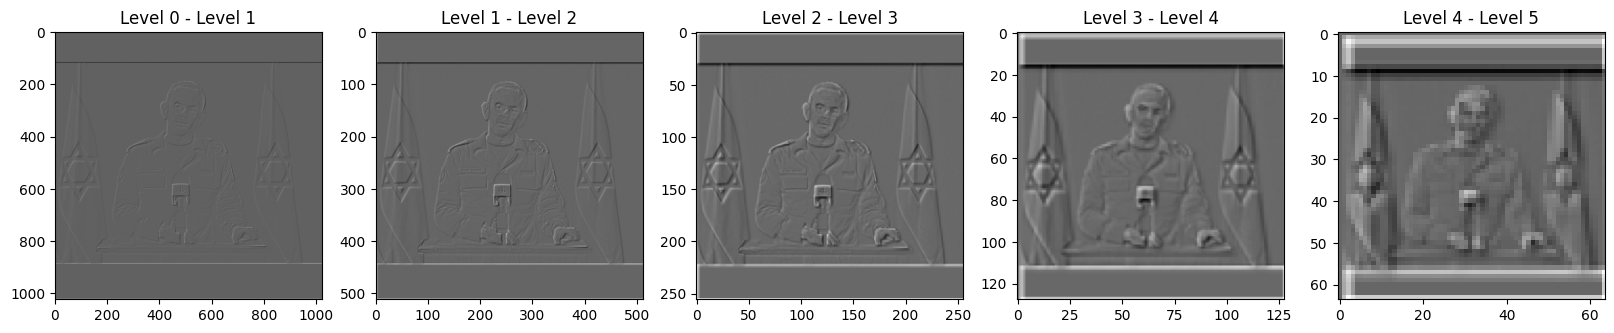

In [105]:
plot_pyramid_diff(blended_pyramid)